---   
<img align="left" width="75" height="75"  src="images/pu_logo.png"> 

<h1 align="center">Department of Data Science</h1>
<h1 align="center">Course: Tools and Techniques for Data Science</h1>

---
<h3><div align="right">Instructor: Muhammad Arif Butt, Ph.D.</div></h3>    

<h1 align="center" style="font-size: 45px;">Potato Disease Classification</h1>

<img style="margin: auto;" src="images/title.png" />

# 1. Project Statement & overview

## Project Title
Potato Disease Classification using Machine Learning

## Project statement

<div style='margin: auto; max-width: 1400px; text-align: justify; text-justify: inter-word;'>
New diseases are emerging every year and its becoming difficult for farmers to detect these diseases. This project is aimed to develop an automated system for farmers to detect these diseases. For that we’ll build a machine learning model to predict these diseases. After building the model we’ll deploy it to cloud. Where farmers will be able to use it by using downloadable mobile app or on web.
</div>

## Objective
The main idea of the project is to provide farmers an automated way to identify potato diseases.

## Tools & Technologies
 - Neural networks
 - Convolutional neural networks (CNN)
 - Python
 - Jupyter notebooks
 - Tensorflow
 - Keras
 - Matplotlib
 - Numpy
 - Google cloud
 - React.js
 - Progressive web app

# 2. Data Acquisition
Our dataset contains images of Potato plants. The source of data is Kaggle.

# 3. Data Preprocessing
Our data is almost preprocessed. We don't need any further preprocessing.

# Some python stuff

## Install packages & imports

In [1]:
!pip install numpy tensorflow matplotlib

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

## Constants
Some constants that will be usefull later in the notebook

In [3]:
IMG_SIZE = (256, 256)    # Dataset images size
BATCH_SIZE = 32          # No. of images to feed model at each step
CHANNELS = 3             # No. of channels in image
EPOCHS = 20              # No. of training iterations on dataset
TRAIN_SIZE = 0.8         # Ratio of train set from whole dataset
VAL_SIZE = 0.1           # Ratio of validation set from train set
MODEL_INPUT_SHAPE = (BATCH_SIZE, *IMG_SIZE, CHANNELS)

## Loading data
Our data (images) resides inside `Dataset/` directory. And in the dataset Potato plant has 2 diseases `Early blight` & `Late blight`.<br />
So our data (images) are divided into 3 directories inside `Dataset/`:
 - Early_blight
 - Late_blight
 - healthy

We'll use `tensorflow.keras.preprocessing.image_dataset_from_directory(directory)` to read our dataset (images).

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Dataset',              # Path to directory
    shuffle=True,           # Randomize images
    image_size=IMG_SIZE,    # Input image size
    batch_size=BATCH_SIZE   # Divide whole dataset into mini batches for fast training
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
print('Classes in our dataset: ', class_names)

Classes in our dataset:  ['Early_blight', 'Late_blight', 'healthy']


In [6]:
# Randomly shuffling dataset
dataset = dataset.shuffle(10000, seed=12)

# 4. EDA & Visualization
Our project is an machine learning based project. So it doesn't contain so much graphs.

<BarContainer object of 3 artists>

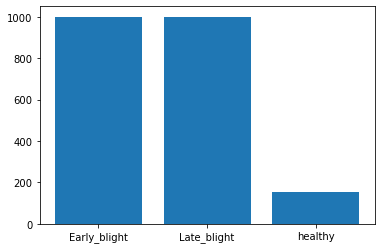

In [7]:
labels = np.concatenate([labels.numpy() for _, labels in dataset.take(100)])
_, labels_counts = np.unique(labels, return_counts=True)
plt.bar(class_names, labels_counts)

## Ploting leaves images
We'll randomly print different images for visualization.

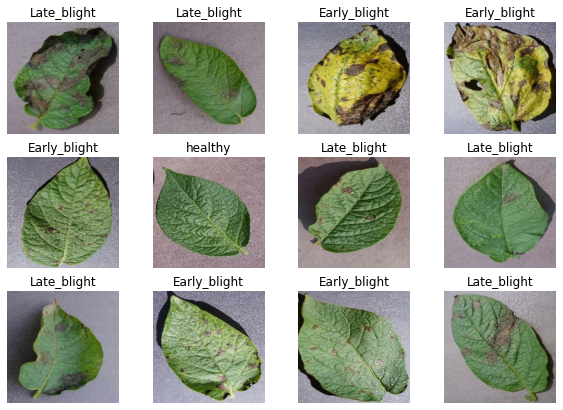

In [8]:
plt.figure(figsize=(10, 7))
for img_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

# 5. Model building & testing

## Train test split
Now we'll split our data into 3 parts.
 - Training
 - Validation
 - Testing

`dataset.skip` & `dataset.take` are functions to select specidied number of data from entire dataset. So we'll use it to split our dataset.

In [9]:
train_size = int(len(dataset)*TRAIN_SIZE)
val_size = int(len(dataset)*VAL_SIZE)

train_set = dataset.take(train_size)
test_set = dataset.skip(train_size).skip(val_size)
val_set = dataset.skip(train_size).take(val_size)

### Prefetching
Prefetching is a technique in which we load next data while our CPU/GPU is busy on current data. This techniques reduces a lot of training time.

In [10]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model building
Here we'll design our model architecture. For our problem we're using `Convolutional neural network (CNN)` (a type of Artificial neural network).

### Preprocessing & Data Augmentation

Here we'll perform some preprocessing on our data before feeding it to original model. For example resizing the image to required size. We'll also perform some data augmentation on dataset. The reason for data augmentation is that because the images in dataset are captured in same direction and zoom level the model our model can make assumptions that this direction and zoom level of leaf is associated with this class label (in simple words it can make our model biased). So to avoid this biasness data augmentation is introduced. And what we're doing in data augmentation is that randomly rescaling, ratating and fliping images.

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(*IMG_SIZE),    # Randomly resizing images
    layers.experimental.preprocessing.Rescaling(1.0/255)      # Randomly rescaling images
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),    # Randomly fliping images
    layers.experimental.preprocessing.RandomRotation(0.2)                       # Randomly rotating images
])

## Designing Model

### Intro to `CNN`

An Convolutional neural network is advanced varient of traditional neural network specialized for images. <br />
There are two parts of every CNN:
 - Convolutional part
 - Fully connected part
 
<img src="images/cnn_architecture.png" style="max-width: 1000px;" />

#### Convolutional part
<div style='max-width: 1000px; text-align: justify; text-justify: inter-word;'>
The main agenda of this part is to reduce no. of dimensions of images and to intelligently recognize different features in image. <br />
In convolution we create an filter of size m×n and convolve it to whole image. As you can see the input image is bigger than the output one. What we do in convolution is that we take sum of products in a small neighbourhood.
</div>

<img src="images/convolution.jpg" style="max-width: 900px" />

#### Fully connected part
<div style='max-width: 1000px; text-align: justify; text-justify: inter-word;'>
This part of CNN is just like a normal ANN it can have hidden layers. And specific number of ouput neurons (according to your need).
</div>
<img src="images/dense_network.jpg" style="max-width: 600px;" />

### Architecture of our model
Our model has three main parts:
 - **Data augumentation**: It is used to remove biasness in our model.
 - **Convolutional part**: It is used to reduce dimensions of our data we're using convolutional part. We're taking 6 layers of `convolution` and `max pooling`. The convolution recognize features from image. And max pooling reduces the dimensions.
 - **Fully connected part**: This is the main part of our model which is used to learn different classes in our data. And we're taking two layers of it. One hidden and second layer is output layer.
 
#### Activation functions
`relu` is used in convolution and one hidden layer while `softmax` is used in the output layer.

In [13]:
model = models.Sequential([
    # Data augmentation layers
    resize_and_rescale,
    data_augmentation,
    
    # Convolutional part
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=MODEL_INPUT_SHAPE),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flattening our image
    layers.Flatten(),
    
    # Fully connected part
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax'),
])

#### Compiling model
Model compilation is used to define `loss function` & `optimizer`. <br />
`Loss function`: is used to calculate the error of our model. It is crucial while training your model. Some popular loss functions are `MSE`, `MAE` and `BinaryCrossentropy`. <br />
`Optimizer`: An optimizer is a method by which we perform model training. Some popular optimizers are `Adam`, `Stochastic Gradient Descent` and `RMSProp`

In [14]:
model.build(MODEL_INPUT_SHAPE)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
model.summary()    # Print short summary of model like its architecture, no. of parameters

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

## Training
Now its time to train our model. We'll provide our model the dataset and it will start its training. The time for training depends on machine. On normal computers/laptops it may take 1 hour to complete the training.

In [16]:
training_history = model.fit(
    train_set,                    # Training set
    epochs=EPOCHS,                # No. of iterations to do on same training set
    batch_size=BATCH_SIZE,        # Size of mini batch (for optimization)
    verbose=1,                    # Show logs while training
    validation_data=val_set,      # Validation set for checking model accuracy during training
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)]      # If model accuracy is not increasing anymore then it stop the further training
)

Epoch 1/20
54/54 [==============================] - 146s 3s/step - loss: 0.9166 - accuracy: 0.4930 - val_loss: 0.9598 - val_accuracy: 0.4948
Epoch 2/20
54/54 [==============================] - 143s 3s/step - loss: 0.7192 - accuracy: 0.6596 - val_loss: 0.5280 - val_accuracy: 0.7656
Epoch 3/20
54/54 [==============================] - 154s 3s/step - loss: 0.3946 - accuracy: 0.8327 - val_loss: 0.6659 - val_accuracy: 0.7760
Epoch 4/20
54/54 [==============================] - 174s 3s/step - loss: 0.2645 - accuracy: 0.8867 - val_loss: 0.2457 - val_accuracy: 0.9115
Epoch 5/20
54/54 [==============================] - 231s 4s/step - loss: 0.2306 - accuracy: 0.9137 - val_loss: 0.1601 - val_accuracy: 0.9583
Epoch 6/20
54/54 [==============================] - 160s 3s/step - loss: 0.2138 - accuracy: 0.9114 - val_loss: 0.1419 - val_accuracy: 0.9479
Epoch 7/20
54/54 [==============================] - 195s 4s/step - loss: 0.1662 - accuracy: 0.9396 - val_loss: 0.0840 - val_accuracy: 0.9740
Epoch 8/20
54

### Accuracy during accuracy
Below in the graph you can see there are four lines.
 - **Loss**: Loss of model after every epoch (in test set)
 - **Accuray**: Accuracy of model after each epoch (in test set)
 - **Validation loss**: Loss of model for validation set
 - **Validation accuracy**: Accuracy of model for validation set

By viewing the trend of these matrices you can decide when to how much epochs you need

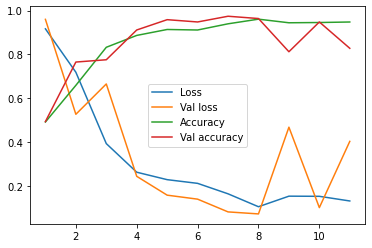

In [22]:
x = range(1, len(training_history.history['loss'])+1)
plt.plot(x, training_history.history['loss'], label='Loss')
plt.plot(x, training_history.history['val_loss'], label='Val loss')
plt.plot(x, training_history.history['accuracy'], label='Accuracy')
plt.plot(x, training_history.history['val_accuracy'], label='Val accuracy')
plt.legend()

## Saving the model
We'll save the model so that we can you it else where.

`tensorflow.keras.model.save(filepath)` is a method by which we can save our model to disk.

In [18]:
model.save('models/temp.h5')

## Tesing
We'll now evaluate our model using `tensorflow.keras.model.evaluate()` to see its accuracy on test data.

In [19]:
loss, accuracy = model.evaluate(
    test_set,
    verbose=0    # Turn off the logs
)
print(f'This is the accuracy & loss of our model on whole test dataset.\nAccuracy : {accuracy}\nLoss     : {loss}')

This is the accuracy & loss of our model on whole test dataset.
Accuracy : 0.79296875
Loss     : 0.6049248576164246


### Randomly predicting images
Here we're just randomly feeding images to model and making predictions.

In [20]:
def make_prediction(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

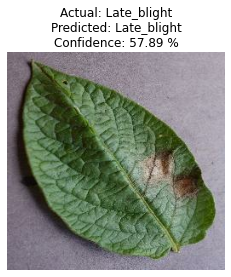

In [21]:
for images, labels in test_set.take(1):
    predicted_class, confidence = make_prediction(model, images[0].numpy())
    actual_class = class_names[labels[0]]
    
    plt.imshow(images[0].numpy().astype('uint8'))
    plt.title(f'Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence} %')
    plt.axis('off')

# 6. Deployment
This project is an end project which user can easily use. There is an webapp which can easily be install on any device natively. The webapp is developed in React.js using Progressive web app (PWA). The webapp uses an API to predict the leaf photos. The API is provided by an cloud service hosted at Google Cloud Plateform (GCP).

# Refrences
1. Plant Village Dataset https://www.kaggle.com/emmarex/plantdisease
2. Codebasics github repository https://github.com/codebasics/potato-disease-classification
3. Codebasics youtube playlist https://www.youtube.com/playlist?list=PLeo1K3hjS3ut49PskOfLnE6WUoOp_2lsD